## Pt 1 - Thefuzz

In [32]:
# imports 
import pandas as pd
from thefuzz import process

# load data
path = '/Users/Marcy_Student/Desktop/clean_full_collisions.csv'
df = pd.read_csv(path)


In [33]:
vehicle_cols = ['vehicle_type_code_1','vehicle_type_code_2','vehicle_type_code_3',
                'vehicle_type_code_4','vehicle_type_code_5']


unique_vehicles = pd.unique(df[vehicle_cols].values.ravel()) # makes 1-dimensional and only takes each value once

unique_vehicles = sorted([v for v in unique_vehicles if pd.notna(v)]) # sorted list without missing values

unique_vehicles # displays all unique vehicle types in the dataset. helps to preview before making categories

['-',
 '.',
 '0',
 '000',
 '0000',
 '09',
 '10 Paaseng',
 '100th truc',
 '12 PASSENG',
 '13',
 '16m',
 '17',
 '18 WHEELER',
 '18 wheeler',
 '2',
 '2 dr sedan',
 '2 wheel sc',
 '263',
 '2YDSWHEELL',
 '3 Wheel Sc',
 '3 Wheel Ve',
 '3-Door',
 '325FLCR',
 '340AJ',
 '4',
 '4 dr sedan',
 '4 wheeler',
 '4door',
 '4dsd',
 '5',
 '50CC SCOOT',
 '50cc mini',
 '7',
 '787',
 '997',
 '999',
 'A',
 'A bulance',
 'A,n',
 'ABMU',
 'ABULANCE',
 'ACCESS A R',
 'ACCESS RID',
 'ACCESS-ARI',
 'ACUR',
 'ALL TERRAI',
 'AMAZON TRU',
 'AMAZON VAN',
 'AMB',
 'AMBALANCE',
 'AMBLUANCE',
 'AMBU',
 'AMBULACE',
 'AMBULANCE',
 'AMBULANCE`',
 'AMBULANE',
 'AMBULANVE',
 'AMBULENCE',
 'AMBULETTE',
 'AMSGC',
 'AMULANCE',
 'APP',
 'APPORTIONE',
 'ARCIMOTO',
 'ARMORED TR',
 'ASPHALT RO',
 'ATTECHMENT',
 'AUTOTRLR T',
 'Access A R',
 'Access a R',
 'Access-A-R',
 'All-Terrain Vehicle',
 'Amazon Van',
 'Amazon del',
 'Amazon tru',
 'Amazon van',
 'Amb',
 'Ambu',
 'Ambulance',
 'Ambulances',
 'Ambulence',
 'Ambulette',
 'Appor

In [34]:
motor_categories = [ # list of motor vehicle categories to fuzzymatch
    "Sedan", "SUV", "Taxi", "Pickup Truck", "Van", "Truck", "Bus",
    "Motorcycle", "Moped", "Scooter", "Ambulance", "Fire Truck",
    "Garbage Truck", "Delivery Truck", "Forklift / Construction",
    "Trailer", "Government Vehicle", "Commercial Vehicle", "Unknown"
]


In [35]:
def detect_government(raw):
    if not isinstance(raw, str):
        return None

    s = raw.lower()

    gov_keywords = [
        "fdny", "nypd", "usps", "postal", "mta", "dot",
        "city", "nyc", "ems", "sanitation",
        "gov", "government", "parks", "transit"
    ]

    # if any keyword matches, return a label
    if any(k in s for k in gov_keywords):
        return "Government Vehicle"

    return None


In [36]:
def fuzzy_motor_class(raw): # function to match motor catagories
    if not isinstance(raw, str): # if the input is not a string, return Unknown
        return "Unknown"
    clean = raw.strip() # remove leading and trailing whitespace

    match, score = process.extractOne(clean, motor_categories) # returns motor catagory if match score is high enough

    
    return match if score >= 70 else "Unknown" # adjust threshold depending on how wild the data is


In [37]:
def classify_government(raw):
    gov = detect_government(raw)
    if gov is not None:
        return gov

    return fuzzy_motor_class(raw)
    
df["VEHICLE CLEAN"] = df["VEHICLES COMBINED"].apply(classify_government)


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  | 

In [38]:
df['VEHICLES COMBINED'] = df[vehicle_cols].fillna('').agg(' | '.join, axis=1) 
# fills missing values with an empty space, then combines vehicle type columns into one string per row. makes it easier to run fuzzy matching
#  or electric detection on all vehicles in the crash at once, instead of checking each column individually. **IMPORTANT** technically losing data because it puts
# all vehicle types into one string, but for this analysis it's acceptable(Note as constraint).






In [46]:
df["VEHICLE CLEAN"].value_counts()

VEHICLE CLEAN
Sedan                            154019
Government Vehicle               149494
Pickup Truck                      14175
Unknown                           13562
Electric Bike                      8202
Taxi                               6725
Truck                              5966
Electric Scooter                   5021
Motorcycle                         3976
Bus                                2412
Ambulance                          1619
Van                                1497
Moped                              1377
Garbage Truck                       806
Scooter                             497
Fire Truck                          149
Delivery Truck                      136
Trailer                             119
SUV                                  93
Forklift / Construction              56
Electric Other                       37
Commercial Vehicle                   33
Electric Motorcycle                  19
Electric Unicycle / One-Wheel        11
Name: count, dtype: int64

In [40]:
government_categories = [
    "Government Vehicle",
    "Fire Truck",
    "Ambulance",
    "Bus",          # MTA / public buses
    "Garbage Truck",
    "Delivery Truck"  # USPS, city delivery
]


df["is_government"] = df["VEHICLE CLEAN"].apply(lambda x: 1 if x in government_categories else 0)


print(df["is_government"].value_counts())
print(f'\n',df["is_government"].value_counts(normalize=True))

is_government
0    212184
1    157817
Name: count, dtype: int64

 is_government
0    0.573469
1    0.426531
Name: proportion, dtype: float64


In [41]:
# crashes with at least one electric vehicle
government_crashes = df[df["is_government"] == 1]

# total injured and killed
total_injured = government_crashes["number_of_persons_injured"].sum()
total_killed = government_crashes["number_of_persons_killed"].sum()
# crashes where no one was injured or killed
no_injury_crashes = government_crashes[
    (government_crashes["number_of_persons_injured"] == 0) &
    (government_crashes["number_of_persons_killed"] == 0)]

total_no_injury_crashes = no_injury_crashes.shape[0]

print(f"Total persons injured in government vehicle crashes: {total_injured}")
print(f"Total persons killed in government vehicle crashes: {total_killed}")
print(f"Number of government vehicle crashes with no injury or death: {total_no_injury_crashes}")

# in case i get confused again,  this total number of people involved in crashes, unlike is_electric which is total number of crashes with electric vehicles


Total persons injured in government vehicle crashes: 88938
Total persons killed in government vehicle crashes: 384
Number of government vehicle crashes with no injury or death: 95305


## Pt 2 Time

/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_16999/3765932878.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_injuries.index, y=season_injuries.values, palette='viridis')


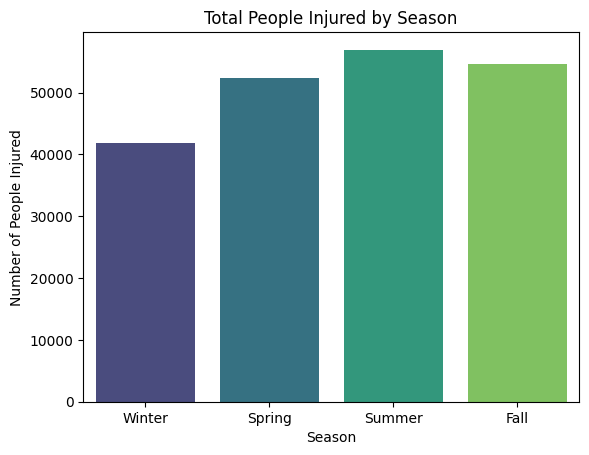

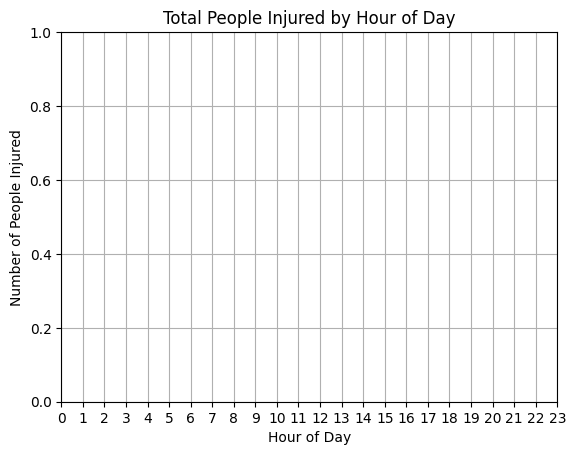

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df['crash_date'] = pd.to_datetime(df['crash_date'], errors='coerce')
df['crash_time'] = pd.to_datetime(df['crash_time'], format='%H:%M', errors='coerce').dt.hour


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['crash_date'].dt.month.apply(get_season)


season_injuries = df.groupby('Season')['number_of_persons_injured'].sum().reindex(['Winter','Spring','Summer','Fall'])


sns.barplot(x=season_injuries.index, y=season_injuries.values, palette='viridis')
plt.title('Total People Injured by Season')
plt.ylabel('Number of People Injured')
plt.xlabel('Season')
plt.show()


hour_injuries = df.groupby('crash_time')['number_of_persons_injured'].sum()



sns.lineplot(x=hour_injuries.index, y=hour_injuries.values, marker='o')
plt.title('Total People Injured by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of People Injured')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

## Pt 3 - Factors


In [43]:
import pandas as pd
from thefuzz import process

df = pd.read_csv(path)

list1 = df['contributing_factor_vehicle_1'].tolist()
list2 = df['contributing_factor_vehicle_2'].tolist()
list3 = df['contributing_factor_vehicle_3'].tolist()
list4 = df['contributing_factor_vehicle_4'].tolist()
list5 = df['contributing_factor_vehicle_5'].tolist()

list6 = list1 + list2 + list3 + list4 + list5

unique_factors = set([factor for factor in list6 if isinstance(factor, str)])
unique_factors

{'Accelerator Defective',
 'Aggressive Driving/Road Rage',
 'Alcohol Involvement',
 'Animals Action',
 'Backing Unsafely',
 'Brakes Defective',
 'Cell Phone (hand-Held)',
 'Cell Phone (hands-free)',
 'Driver Inattention/Distraction',
 'Driver Inexperience',
 'Driverless/Runaway Vehicle',
 'Drugs (illegal)',
 'Eating or Drinking',
 'Failure to Keep Right',
 'Failure to Yield Right-of-Way',
 'Fatigued/Drowsy',
 'Fell Asleep',
 'Following Too Closely',
 'Glare',
 'Headlights Defective',
 'Illnes',
 'Lane Marking Improper/Inadequate',
 'Listening/Using Headphones',
 'Lost Consciousness',
 'Obstruction/Debris',
 'Other Electronic Device',
 'Other Lighting Defects',
 'Other Vehicular',
 'Outside Car Distraction',
 'Oversized Vehicle',
 'Passenger Distraction',
 'Passing Too Closely',
 'Passing or Lane Usage Improper',
 'Pavement Defective',
 'Pavement Slippery',
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
 'Physical Disability',
 'Prescription Medication',
 'Reaction to Uninvol

In [44]:
df.columns

Index(['Unnamed: 0', 'crash_date', 'crash_time', 'borough', 'zip_code',
       'latitude', 'longitude', 'location', 'on_street_name',
       'cross_street_name', 'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5',
       'month', 'season', 'VEHICLES COMBINED', 'VEHICLE CLEAN', 'is_electric',
       'total_injury_death', 'total_injury_death_flag'],
      dtype='object')